In [1289]:
import urllib.request
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import re
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import json
import requests
import geopandas as gpd
from geopandas import GeoDataFrame
import fiona
from shapely.geometry import Point
from IPython import display
from IPython.display import display, clear_output
import warnings

> Scraping data from Wikipedia using beautifulsoup

In [1260]:
## Creating wikipedia link
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()

In [1261]:
## Using BeautifulSoup to import and parse data
soup = BS(resulttext, 'html.parser')
soup.prettify

<bound method Tag.prettify of <!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of deadly earthquakes since 1900 - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":810533305,"wgRevisionId":810533305,"wgArticleId":11673441,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from Jul

In [1262]:
## Find the earthquake table using it's unique class
table = soup.find('table', class_ = 'sortable wikitable')

## Find all rows within the table
table = table.find_all('tr')

## Empty data list to store table values
data = []

## Loop that looks for table data from rows, then strips the text and stores it as a list
for row in table:
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)

## Create a DataFrame from our stripped data
eq_df = pd.DataFrame(data)
eq_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,None,None,None,None,None,None,None,None,None,None,None,None
1,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,
2,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,
3,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,
4,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,


In [1263]:
## Rename column headers
eq_df.columns = ['origin','country','lat','long','depth_km','magnitude','sec_effects','shaking_death','pde_total','utsu_total','em_total','other_deaths']

In [1264]:
## Export messy Dataframe to a .csv
# eq_df.to_csv('/Users/Justin/Code/data-question-3-xtreme-united/eq_df.csv')

In [1265]:
## Drop the empty first row
eq_df = eq_df.drop(0,0)

## Rename columns
eq_columns = ['origin','country','lat','long','depth_km','magnitude','sec_effects','shaking_death','pde_total','utsu_total','em_total','other_deaths']

In [1266]:
## Regex function
def eq_reg(eq_col, reg_phrase):
    eq_df[eq_col] = eq_df[eq_col].str.replace(reg_phrase, '')

## Cleaning columns
eq_reg('magnitude', '([a-zA-Z])')
eq_reg('magnitude','\[..\]')
eq_reg('other_deaths', '\[.*\]')
eq_reg('em_total', '\[7\].')
eq_reg('country', '\([^\)]*\)*')
eq_reg('other_deaths', '\([^\)]*\)*')
eq_reg('other_deaths', '\+')
eq_reg('other_deaths', '26271 26000')
eq_reg('other_deaths', '231000* 283000* 227898*')
eq_reg('other_deaths', '\*')


In [1267]:
## Converts column to float
def float_convert(df,col):
    df[col] = pd.to_numeric(df[col], errors ='coerce')

## Float conversions
float_convert(eq_df, 'pde_total')
float_convert(eq_df, 'utsu_total')
float_convert(eq_df, 'em_total')
float_convert(eq_df, 'other_deaths')
float_convert(eq_df, 'magnitude')

In [1268]:
## Grabbing the highest value from the death columns
eq_df['deaths'] = eq_df[['pde_total','utsu_total','em_total','other_deaths']].max(axis=1)

In [1269]:
## Cleaning up empty spaces and changing to floats 
eq_df[eq_df['lat'] == ''] = np.nan
eq_df[eq_df['long'] == ''] = np.nan

## Drop na's
eq_df= eq_df.dropna(subset=['lat','long','deaths'])

## Additional float conversions
float_convert(eq_df, 'lat')
float_convert(eq_df, 'long')
float_convert(eq_df, 'deaths')

In [1270]:
## Converting wikipedia data to Geopandas

geometry = [Point(xy) for xy in zip(eq_df.long, eq_df.lat)]
df = eq_df.drop(['long', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
eq_df = GeoDataFrame(eq_df, crs=crs, geometry=geometry)

>Bringing in live data

In [1271]:
## API site: https://earthquake.usgs.gov/fdsnws/event/1/#format-geojson

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&minmagnitude=5.0&orderby=time&limit=5000'
request = requests.get(url)
b = bytes(request.content)
with fiona.BytesCollection(b) as f:
    crs = f.crs
    gdf = gpd.GeoDataFrame.from_features(f, crs=crs)
    print(gdf.head(20))

    alert  cdi      code                                             detail  \
0   green  0.0  2000c3y6  https://earthquake.usgs.gov/fdsnws/event/1/que...   
1          4.3  2000c3ms  https://earthquake.usgs.gov/fdsnws/event/1/que...   
2   green  5.8  2000c3mi  https://earthquake.usgs.gov/fdsnws/event/1/que...   
3   green  4.2  2000c3ag  https://earthquake.usgs.gov/fdsnws/event/1/que...   
4   green  5.8  2000c2xt  https://earthquake.usgs.gov/fdsnws/event/1/que...   
5   green  0.0  2000c2vg  https://earthquake.usgs.gov/fdsnws/event/1/que...   
6   green  6.2  2000c2ue  https://earthquake.usgs.gov/fdsnws/event/1/que...   
7   green  0.0  2000c2te  https://earthquake.usgs.gov/fdsnws/event/1/que...   
8          0.0  2000c2mh  https://earthquake.usgs.gov/fdsnws/event/1/que...   
9          0.0  2000c2jd  https://earthquake.usgs.gov/fdsnws/event/1/que...   
10  green  0.0  2000c2du  https://earthquake.usgs.gov/fdsnws/event/1/que...   
11  green  2.0  2000c286  https://earthquake.usgs.go

In [1272]:
live_df = gdf
# live_df.to_csv('/Users/Justin/Code/data-question-3-xtreme-united/live_eq_api_return.csv')

>Created a function that uses the slider to filter the table by magnitude

In [1273]:
## Use a built-in world shp file
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [1298]:
def mag_slider(x):
    clear_output(wait=True)
    pylab.rcParams['figure.figsize'] = 20, 20
    base = world.plot(color='black', edgecolor='grey')
    for row in eq_df:
        eq_bool = x < eq_df['magnitude']
        eq_table = eq_df[eq_bool==True]
        eq_table.plot(ax=base, marker='o', alpha = 0.6, column = 'magnitude', cmap = 'autumn', markersize = 20);
    for row in live_df:
        live_bool = x < live_df['mag']
        live_table = live_df[live_bool==True]
        live_df.plot(ax=base, marker='o', alpha = 1.0, column ='mag', cmap = 'Blues', markersize = 20);
    return plt.show()

In [1299]:
mag = widgets.FloatSlider(
    value=4.5,
    min=5.0,
    max=10.0,
    step=0.1,
    description='Magnitude',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

## interact(function name, function input = slider)

widgets.interact(mag_slider, x = mag)

A Jupyter Widget

<function __main__.mag_slider>

In [1304]:
def country_drop(x, y):
    warnings.filterwarnings('ignore')
    clear_output(wait=True)
    pylab.rcParams['figure.figsize'] = 20, 20
    country = world.loc[world.name == x]
    base = country.plot(color='black', edgecolor='grey')
    fig = base.get_figure()
    fig.patch.set_facecolor('#6793b2')
    base.axis('off')
    for row in eq_df:
        eq_bool = (x == eq_df['country'])&(y < eq_df['magnitude'])
        eq_table = eq_df[eq_bool==True]
        eq_table.plot(ax=base, marker='o', alpha = 0.6, column = 'magnitude', cmap = 'autumn', markersize = 20);
    for row in live_df:
        live_bool = (live_df[live_df["title"].str.contains(x, case=False)])&(y < live_df['mag'])
        live_table = live_df[live_bool==True]
        live_table.plot(ax=base, marker='o', alpha = 1.0, column ='mag', cmap = 'Blues', markersize = 20);
    return plt.show()

A Jupyter Widget

<function __main__.country_drop>

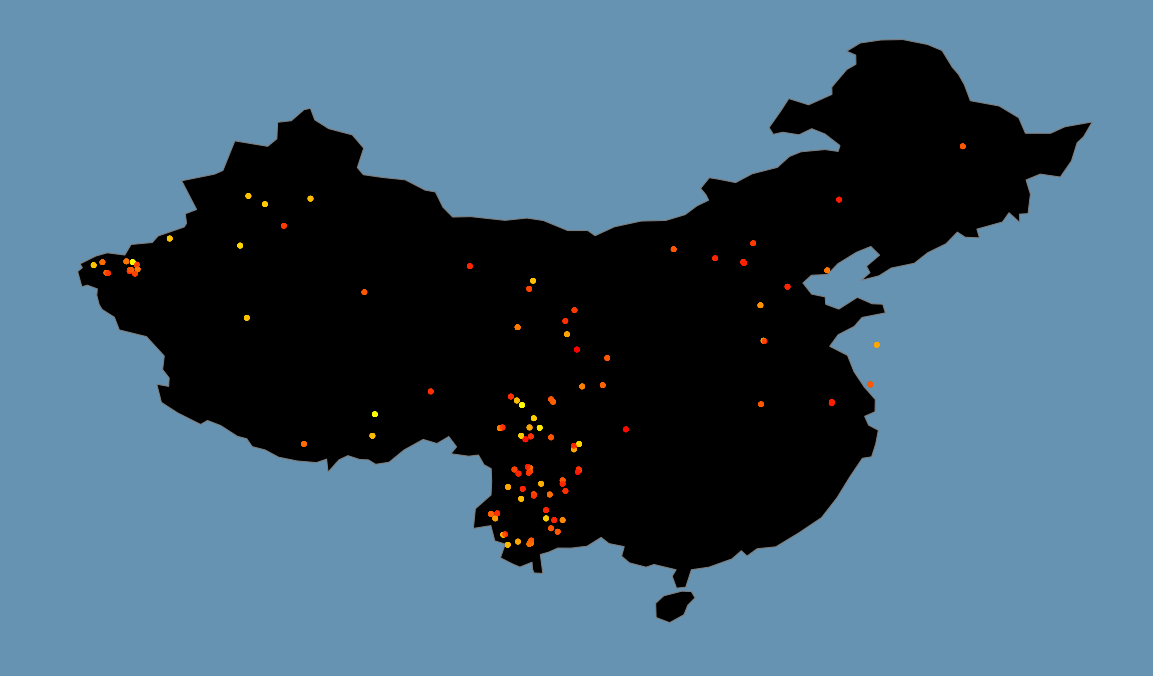

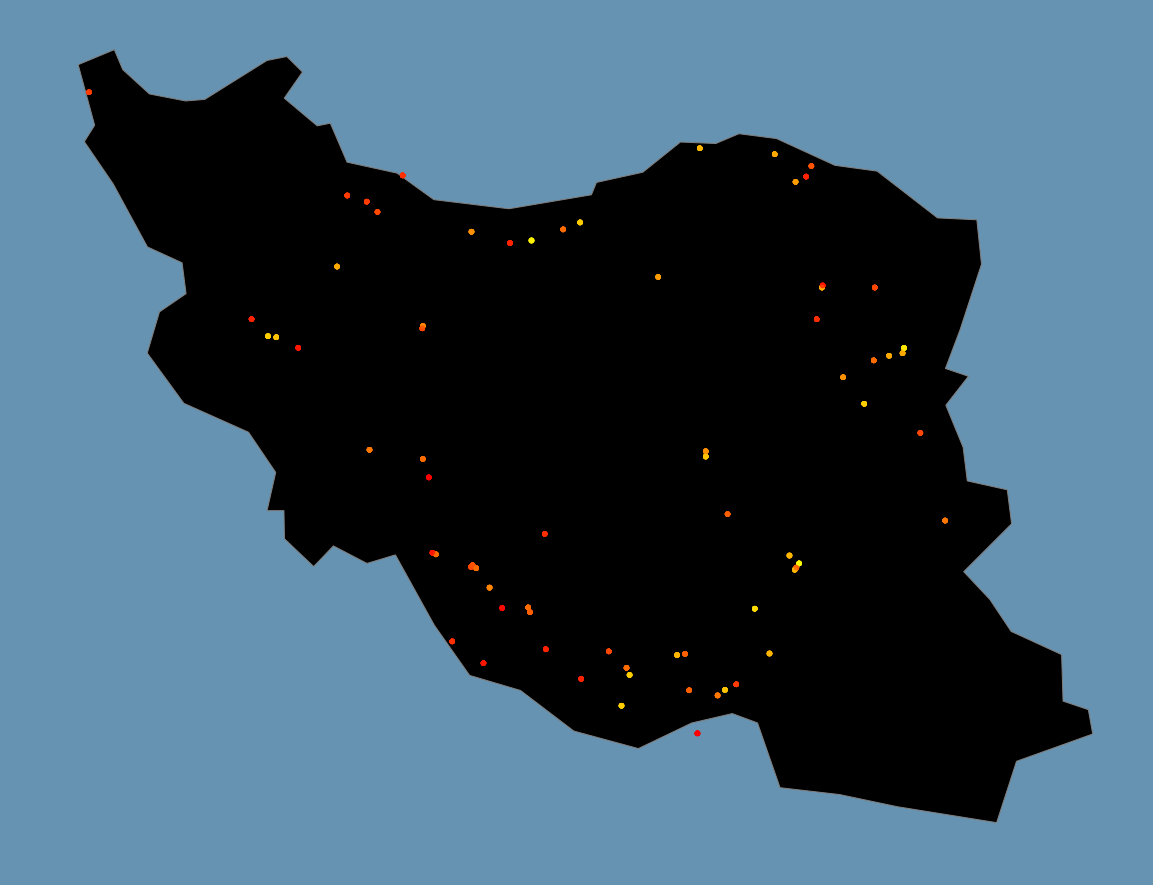

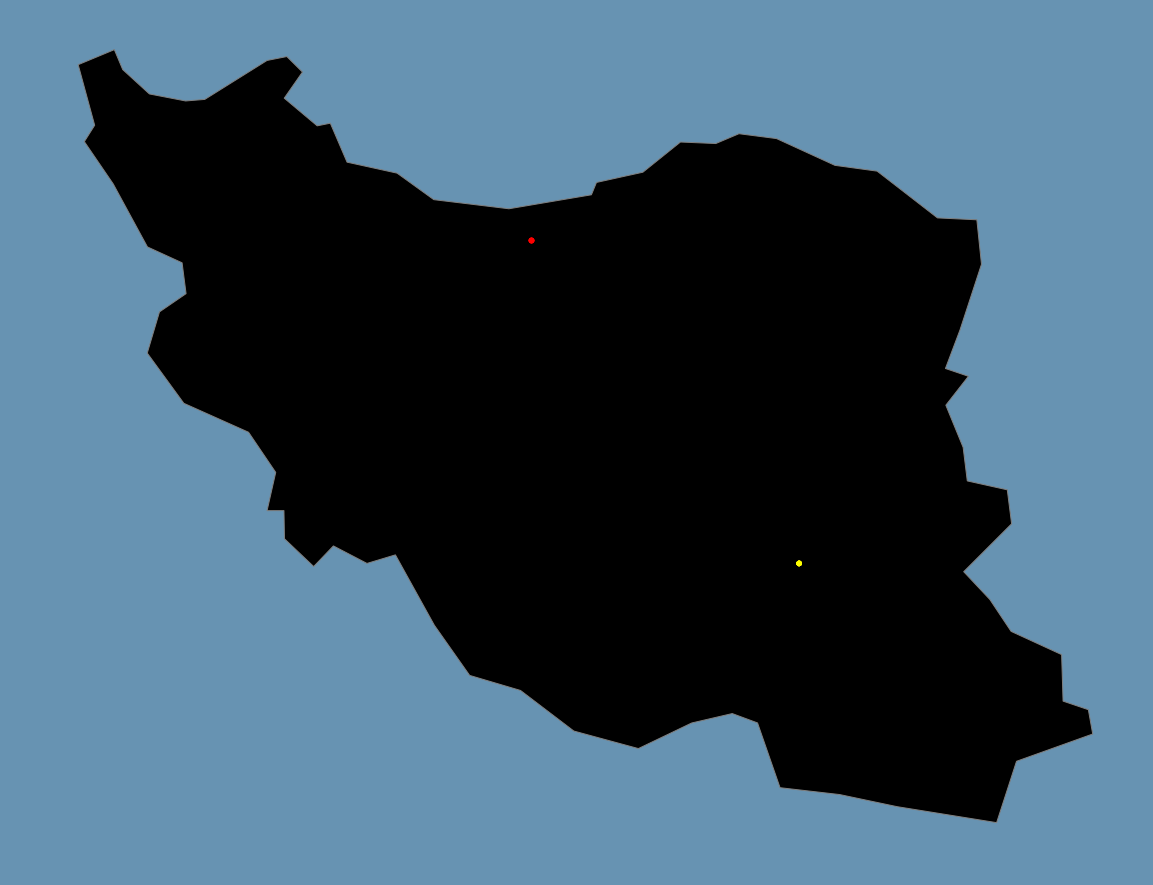

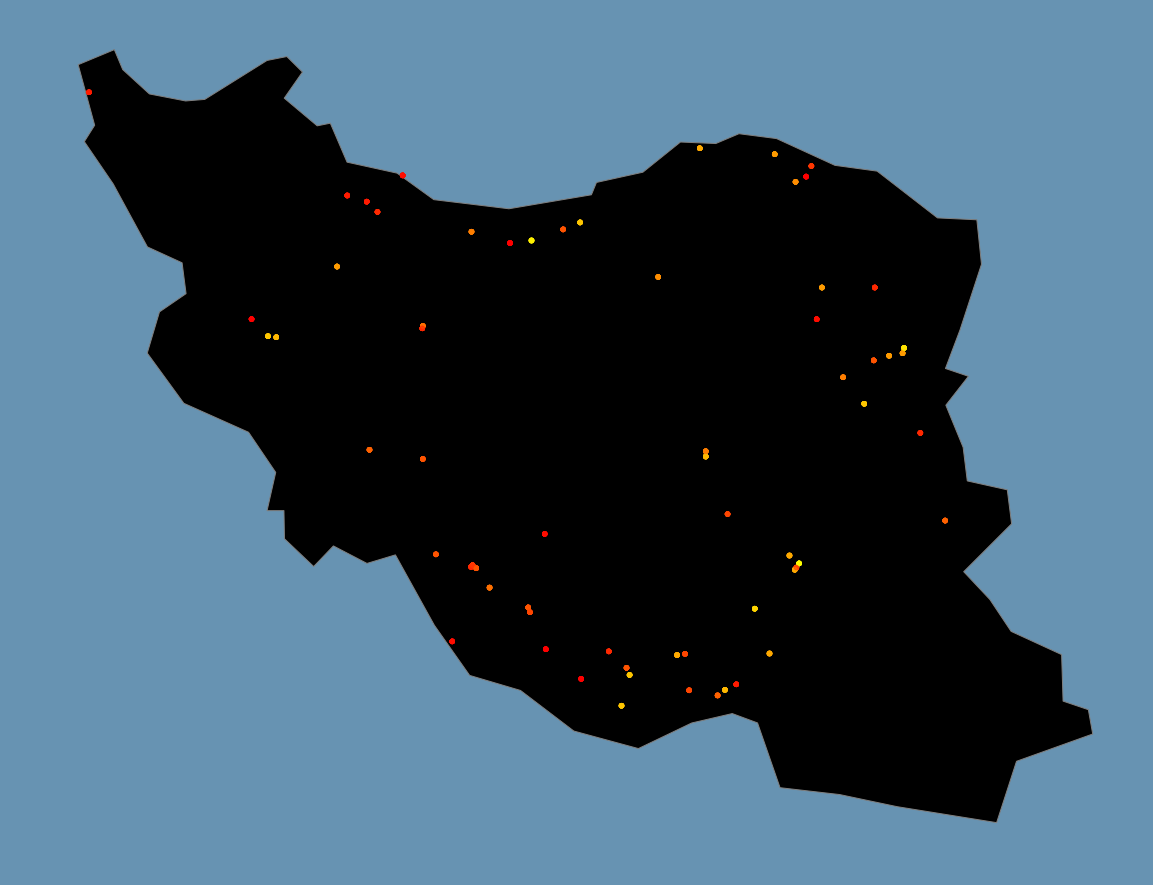

In [1306]:
eq_country = widgets.Dropdown(
    options=[
        'China',
        'Japan',
        'India',
        'United States',
        'Iran'],
    description='Country:',
    disabled=False,
    readout=True,
)

# widgets.interact(country_drop, x= eq_country)

mag = widgets.FloatSlider(
    value=4.5,
    min=5.0,
    max=10.0,
    step=0.1,
    description='Magnitude',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

## interact(function name, function input = slider)

# widgets.interact(mag_slider, y = eq_country)
widgets.interact(country_drop, x= eq_country, y=mag)
# widgets.interact(country_drop, y='mag')

> Still testing everything below

In [1278]:
## Creating an effect description based on magnitude value
def eq_type(df, df_col):
    df['eq_type'] = ''
    for row in df.iterrows():
        if 1.0 <= row[df_col] <= 1.9:
            row['eq_type'] = 'Micro - rarely felt.'
        elif 2.0 <= row[df_col] <= 3.9:
            row['eq_type'] = 'Minor - felt, but no structural damage.'
        elif 4.0 <= row[df_col] <= 4.9:
            row['eq_type'] = 'Light - felt, but minimal structural damage.'
        elif 5.0 <= row[df_col] <= 5.9:
            row['eq_type'] = 'Moderate - varying damage to poorly constructed buildings.'
        elif 6.0 <= row[df_col] <= 6.9:
            row['eq_type'] = 'Strong - moderate damage to well constructed buildings.' 
        elif 7.0 <= row[df_col] <= 7.9:
            row['eq_type'] = 'Major - damage to most buildings, some to partially or completely collapse.'
        elif 8.0 <= row[df_col] <= 8.9:
            row['eq_type'] = 'Great - major damage to buildings, structures likely to be destroyed.'
        elif 9.0 <= row[df_col] <= 9.9:
            row['eq_type'] = 'Catastrophic - severe damage or collapse to all buildings. Permanent changes in ground topography.'
        else:
            row['eq_type'] = 'Not discernible.'
        return df

In [1279]:
## Run description through wikipedia and live data sets
eq_type(eq_df, 'magnitude')
eq_type(live_df, 'mag')

live_df.to_csv('/Users/Justin/Code/data-question-3-xtreme-united/live_eq_desc.csv')

TypeError: tuple indices must be integers or slices, not str

In [ ]:
def cat_drop(x):
    clear_output(wait=True)
    pylab.rcParams['figure.figsize'] = 20, 20
    base = world.plot(color='black', edgecolor='grey')
    fig = ax.get_figure()
    for row in eq_df:
        eq_bool = (x == eq_df['eq_type'])
        eq_table = eq_df[eq_bool==True]
        eq_table.plot(ax=base, marker='o', alpha = 0.6, column = 'magnitude', cmap = 'autumn', markersize = 20);
    for row in live_df:
        live_bool = (x == live_df['eq_type'])
        live_table = live_df[live_bool==True]
        live_table.plot(ax=base, marker='o', alpha = 1.0, column ='mag', cmap = 'Blues', markersize = 20);
    return plt.show()

In [ ]:
eq_cat = widgets.Dropdown(
    options=[
        'Not discernible.',
        'Micro - rarely felt.',
        'Minor - felt, but no structural damage.',
        'Light - felt, but minimal structural damage.',
        'Moderate - varying damage to poorly constructed buildings.',
        'Strong - moderate damage to well constructed buildings.',
        'Major - damage to most buildings, some to partially or completely collapse.',
        'Great - major damage to buildings, structures likely to be destroyed.',
        'Catastrophic - severe damage or collapse to all buildings. Permanent changes in ground topography.'],
    description='Category:',
    disabled=False,
    readout=True,
    value='Moderate - varying damage to poorly constructed buildings.',
)

widgets.interact(cat_drop, x= eq_cat)
